In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [115]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [116]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [117]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [118]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')

    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [119]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [ ]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 10000, 50000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',10,100),
        'random_strength': trial.suggest_uniform('random_strength',40,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_uniform('bagging_temperature', 0, 1),
        'verbose':False,
        'random_state':seed,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 early_stopping_rounds=100
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-18 03:06:13,750] A new study created in memory with name: no-name-c5d90bdf-a01e-4120-b7e3-5314a2b91602
[I 2024-02-18 03:07:17,859] Trial 0 finished with value: 0.7614125714722839 and parameters: {'iterations': 24981, 'learning_rate': 0.9507635921035062, 'reg_lambda': 75.87945476302646, 'random_strength': 75.91950905182219, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.05808361216819946}. Best is trial 0 with value: 0.7614125714722839.
[I 2024-02-18 03:08:40,047] Trial 1 finished with value: 0.7798518013794101 and parameters: {'iterations': 44647, 'learning_rate': 0.6015138967314656, 'reg_lambda': 73.7265320016441, 'random_strength': 41.23506965774815, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.21233911067827616}. Best is trial 1 with value: 0.7798518013794101.
[I 2024-02-18 03:10:37,578] Trial 2 finished with value: 0.7705240487763221 and parameters: {'iterations': 17273, 'learning_rate': 0.1842211053

In [121]:
best_param = study.best_params
best_param 

{'iterations': 44647,
 'learning_rate': 0.6015138967314656,
 'reg_lambda': 73.7265320016441,
 'random_strength': 41.23506965774815,
 'min_data_in_leaf': 49,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.21233911067827616}

In [122]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                verbose=False,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [123]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [124]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4610    10]
 [  690 50470]]

정확도: 0.9875
정밀도: 0.8698
재현율: 0.9978
F1: 0.9294


In [125]:
threshold

0.13828845624795175

In [126]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [127]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred[:], axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1810

In [138]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [136]:
real = pd.read_csv(r'submission(0.7688760806916426).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1643   92]
 [ 167 3369]]

정확도: 0.9509
정밀도: 0.9077
재현율: 0.9470
F1: 0.9269


In [137]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1902

In [131]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

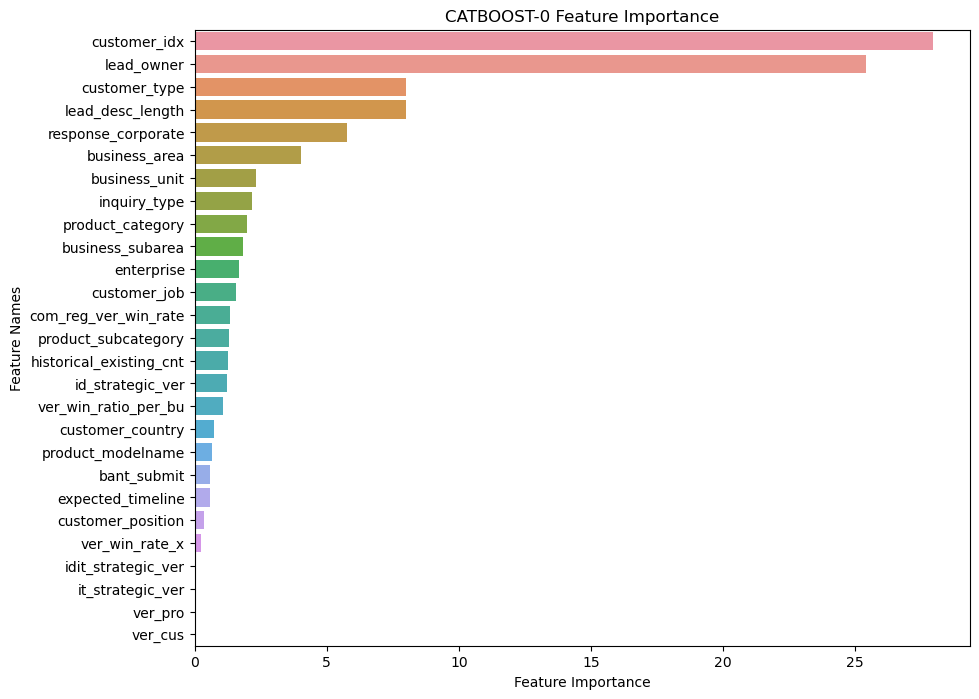

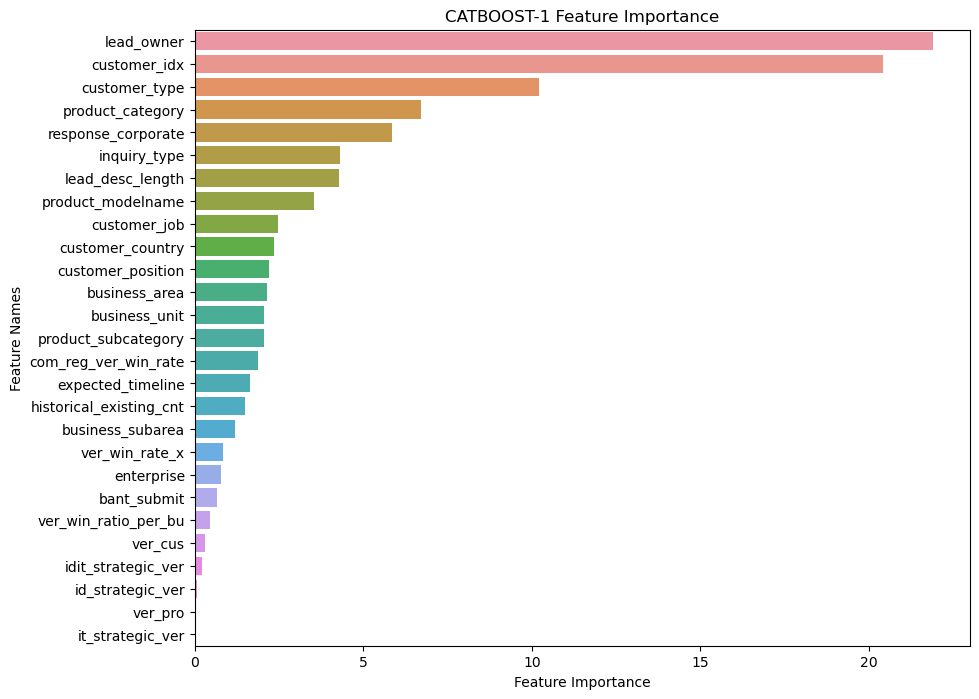

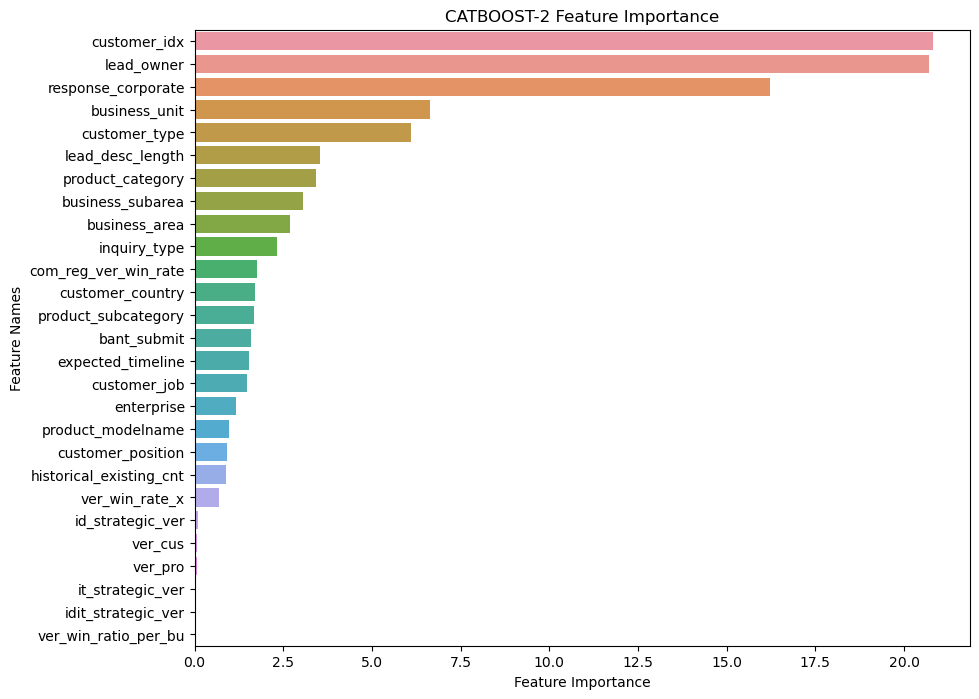

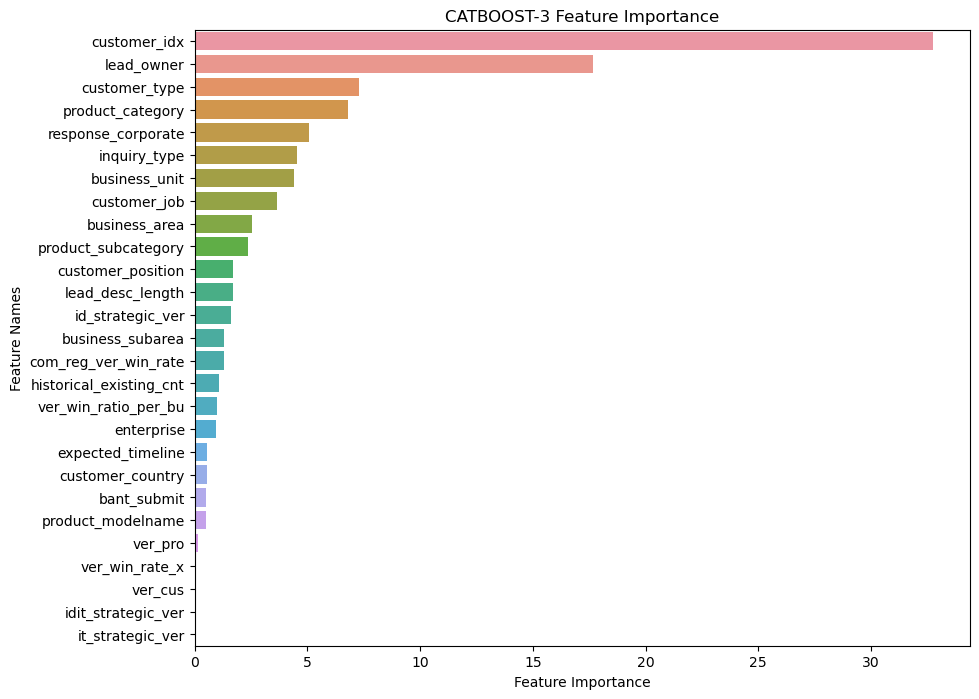

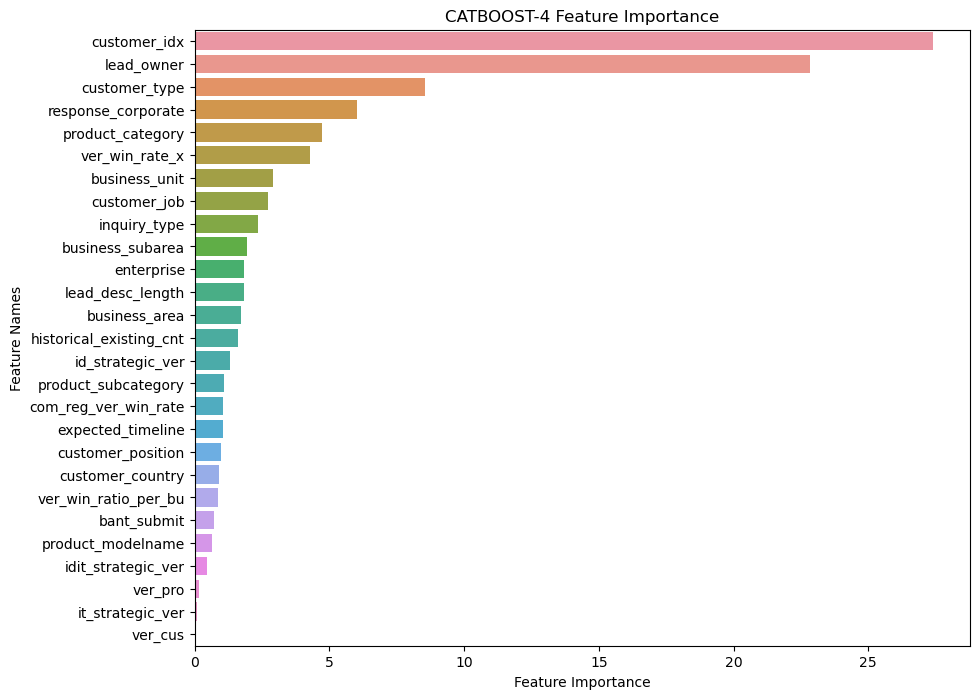

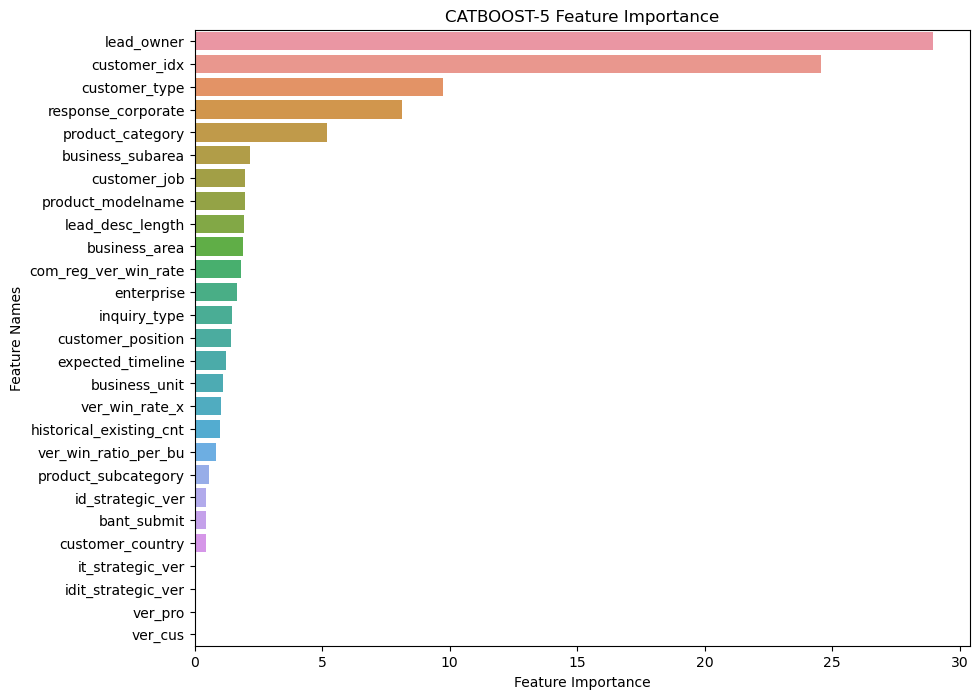

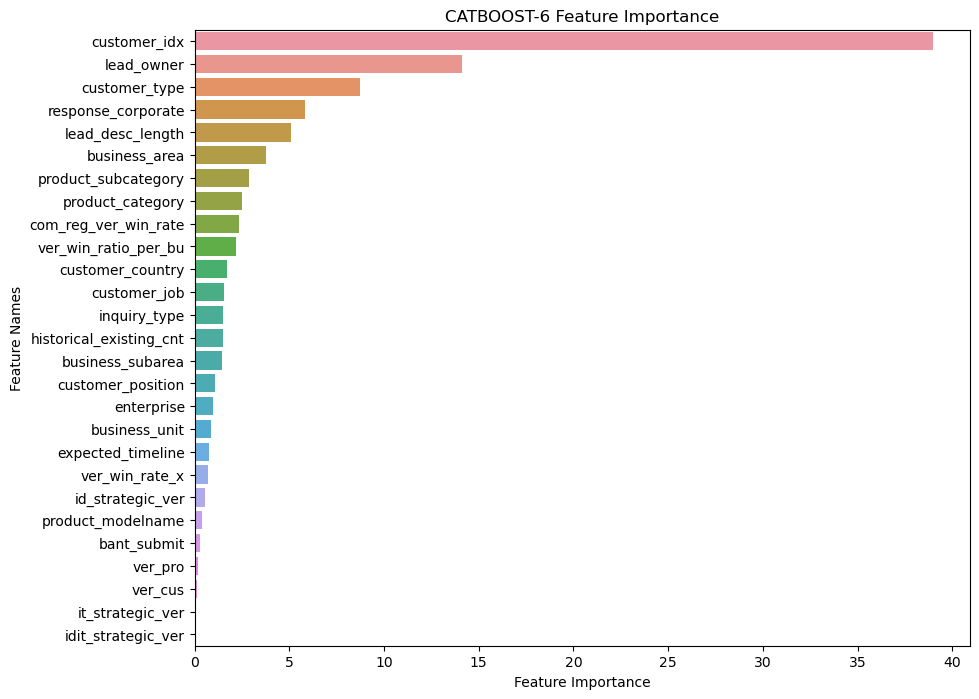

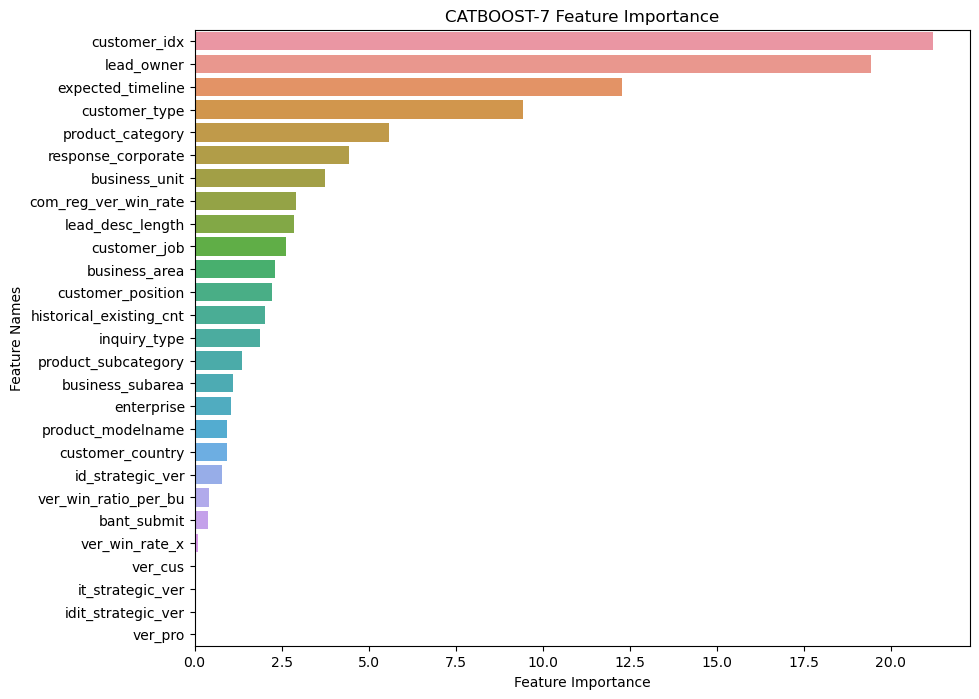

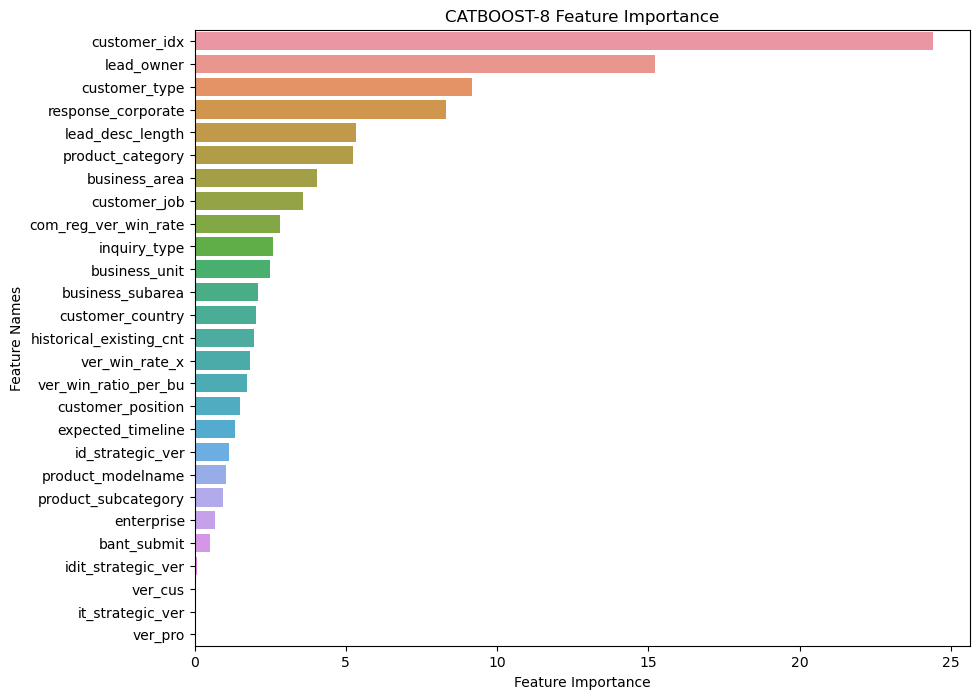

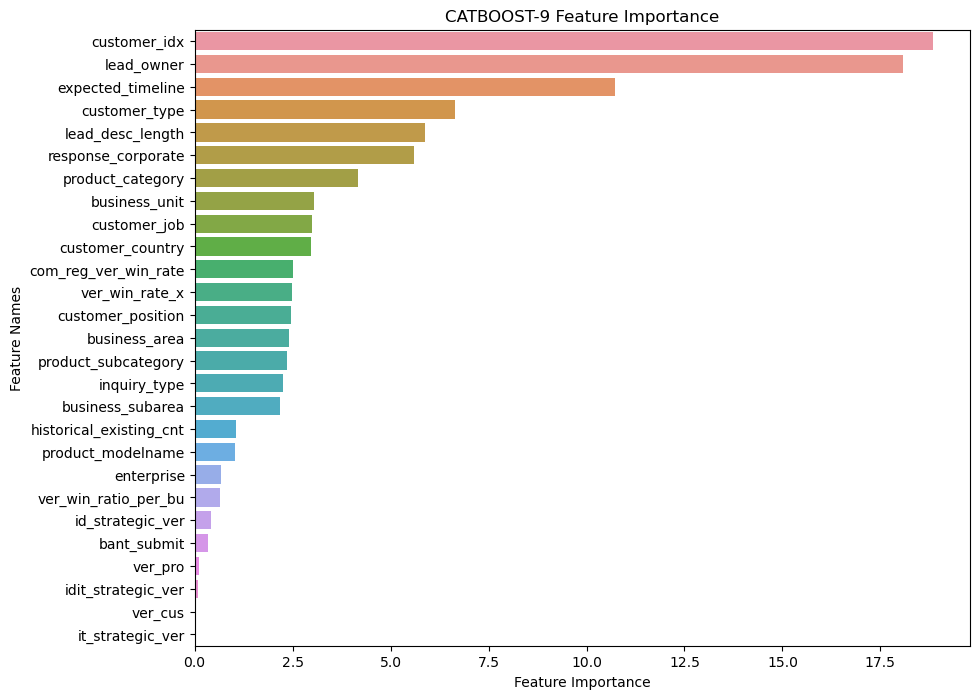

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [133]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4610    10]
 [  690 50470]]

정확도: 0.9875
정밀도: 0.8698
재현율: 0.9978
F1: 0.9294


In [134]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 461    1]
 [  88 5028]]

정확도: 0.9840
정밀도: 0.8397
재현율: 0.9978
F1: 0.9120
오차행렬:
 [[ 461    1]
 [  61 5055]]

정확도: 0.9889
정밀도: 0.8831
재현율: 0.9978
F1: 0.9370
오차행렬:
 [[ 461    1]
 [  70 5046]]

정확도: 0.9873
정밀도: 0.8682
재현율: 0.9978
F1: 0.9285
오차행렬:
 [[ 461    1]
 [  74 5042]]

정확도: 0.9866
정밀도: 0.8617
재현율: 0.9978
F1: 0.9248
오차행렬:
 [[ 461    1]
 [  70 5046]]

정확도: 0.9873
정밀도: 0.8682
재현율: 0.9978
F1: 0.9285
오차행렬:
 [[ 460    2]
 [  47 5069]]

정확도: 0.9912
정밀도: 0.9073
재현율: 0.9957
F1: 0.9494
오차행렬:
 [[ 462    0]
 [  69 5047]]

정확도: 0.9876
정밀도: 0.8701
재현율: 1.0000
F1: 0.9305
오차행렬:
 [[ 462    0]
 [  73 5043]]

정확도: 0.9869
정밀도: 0.8636
재현율: 1.0000
F1: 0.9268
오차행렬:
 [[ 459    3]
 [  70 5046]]

정확도: 0.9869
정밀도: 0.8677
재현율: 0.9935
F1: 0.9263
오차행렬:
 [[ 462    0]
 [  68 5048]]

정확도: 0.9878
정밀도: 0.8717
재현율: 1.0000
F1: 0.9315
